In [1]:
# Pacotes essenciais
import pandas as pd
import matplotlib as mtp
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Pacote de plotagem
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import kurtosis, gaussian_kde
import matplotlib.colors as mcolors

In [2]:
# Pacotes de pré-processamento
import ppscore as pps
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# APIs para aprendizado de máquina
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Introdução

A presente análise tem como objetivo auxiliar uma loja na elaboração de possíveis campanhas de marketings e na venda de serviços ou produtos novos.

Para tal é necessário à identificação de grupos de clientes-alvo e quais seriam suas características principais.

Portanto será analisado um dataset contendo algumas informações básicas dos consumidores do shopping onde essa loja está alocada, como a idade, renda, sexo, etc. A partir destas variáveis será elaborado um algoritmo de clusterização em Python para identificar quais seriam os grupos mais importantes para serem focados/trabalhados pela equipe de marketing.

**<h1>Vizualization data**

In [4]:
data = pd.read_csv('segmentation data.csv')
describe = pd.read_excel('describe_seg.xlsx')

In [5]:
data.head(3)

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0  100000001    0               0   67          2  124670           1   
1  100000002    1               1   22          1  150773           1   
2  100000003    0               0   49          1   89210           0   

   Settlement size  
0                2  
1                2  
2                0

In [6]:
print(tabulate(describe, tablefmt="github",showindex=False))

|-----------------|-------------|-----------|---------------------------------------------------------------------------------------------------------------------------------------------|
| ID              | numerical   | Integer   | Shows a unique identificator of a customer.                                                                                                 |
| Sex             | categorical | {0,1}     | Biological sex (gender) of a customer. In this dataset there are only 2 different options.                                                  |
| nan             | nan         | 0         | male                                                                                                                                        |
| nan             | nan         | 1         | female                                                                                                                                      |
| Marital status  | categorical | {0,1}     | Marital status

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [8]:
data['ID'].duplicated().any()

False

Examinando o dataset carregado com as funções “.info()” e “.duplicated()” não é possível notar a repetição de algum tipo de consumidor em específico ou a presença de dados ausentes. 

Nota-se também que não é possível identificar a qual tipo de ramo a loja analisada pertence por meio das Features apresentadas.

Para um entendimento inicial dos dados será realizado uma visualização da distribuição de cada variável isoladamente.

**<h3>Exploratory Data Analysis**

**Variáveis quantitativas**

(0.0, 1.0, 0.0, 1.0)

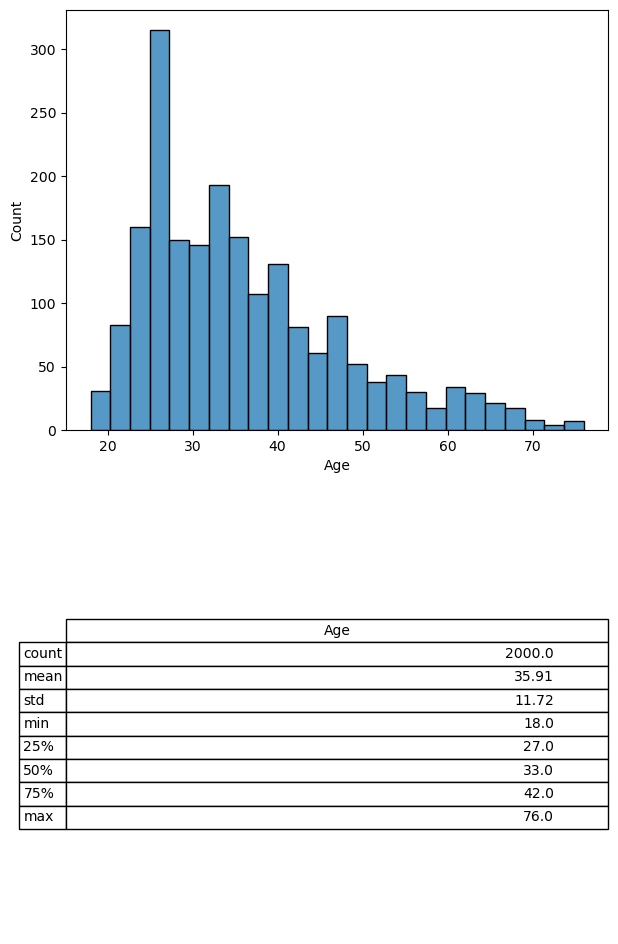

In [9]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7, 12))
table1 = pd.DataFrame(data['Age'].describe().round(2))
sns.histplot(data, x = 'Age', ax = ax1)
ax2.table(cellText= table1.values, colLabels=table1.columns, rowLabels= table1.index, loc = 'center').scale(1, 1.4)
ax2.axis("off") 

Pelos gráficos e pelas tabelas têm-se:

- A média de idade dos compradores é de aproximadamente 36 anos.
- Existe uma grande concentração de pessoas com idades entre aproximadamente 25 a 28 anos.
- A menor idade é de 18 anos e a maior é 76 anos.
- 75% dos dados está concentrado na faixa abaixo dos 42 anos

(0.0, 1.0, 0.0, 1.0)

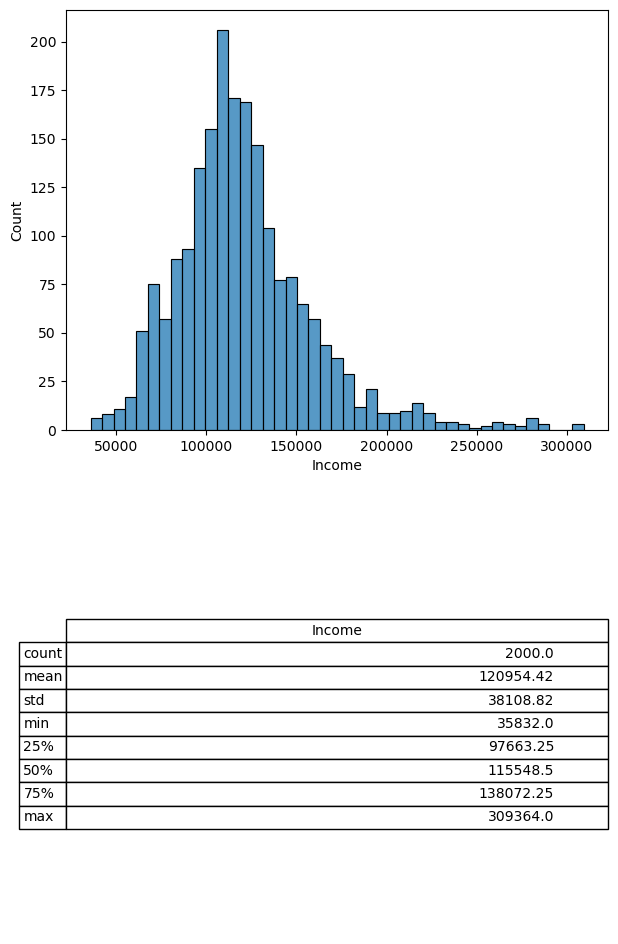

In [10]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7, 12))
table1 = pd.DataFrame(data['Income'].describe().round(2))
sns.histplot(data, x = 'Income', ax = ax1)
ax2.table(cellText= table1.values, colLabels=table1.columns, rowLabels= table1.index, loc = 'center').scale(1, 1.4)
ax2.axis("off") 


Analisando o gráfico e a tabela têm-se:

-  A média de renda anual é de aproximadamente 121,000 tendo um desvio de 40,000.
-  É possível identificar visualmente outliers pelo gráfico, a partir da zona dos 200,000 de renda anual.
-  O mínimo de renda anual é de aproximadamente 35,800 e a máxima é de 309,000.
-  A maior concentração de valores de renda anual é na faixa de 106,000 à 113,000.

**Variáveis categóricas**

Para uma melhor entendimento e vizualização dos dados as features categóricas serão decodificadas com base no 'describe segmentation' disponibilizado.

In [11]:
data_view = data.copy()
data_view['Sex'] = data_view['Sex'].map({1:'female', 0:'male'}) 
data_view['Marital status'] = data_view['Marital status'].map({1:'non-single', 0:'single'}) 
data_view['Education'] = data_view['Education'].map({3:'graduate school', 2:'university', 1:'high school', 0:'unknown'}) 
data_view['Occupation'] = data_view['Occupation'].map({2:'highly qualified employee', 1:'employee', 0:'unemployed '}) 
data_view['Settlement size'] = data_view['Settlement size'].map({2:'big city', 1:'mid-size city', 0:'small city'}) 

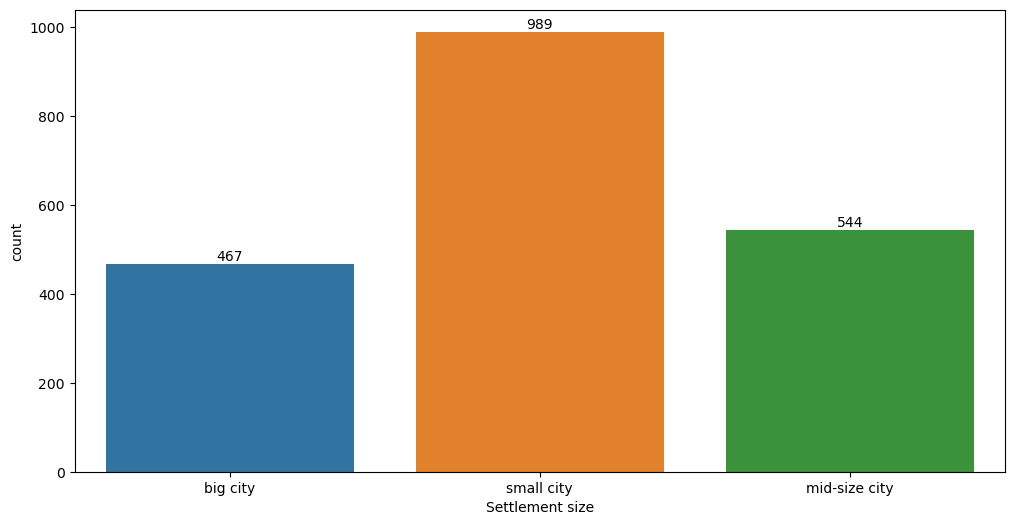

In [12]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Settlement size', data=data_view)
ax.bar_label(ax.containers[0])
plt.show()

Analisando o gráfico nota-se:

-  A maior parte dos dados é composta por pessoas que moram em cidades "small city".
-  O dataset possui menos pessoas vindas de 'big city'.
-  'mid-size city' e 'big city' possuem aproximadamente a mesma quantidade de dados.

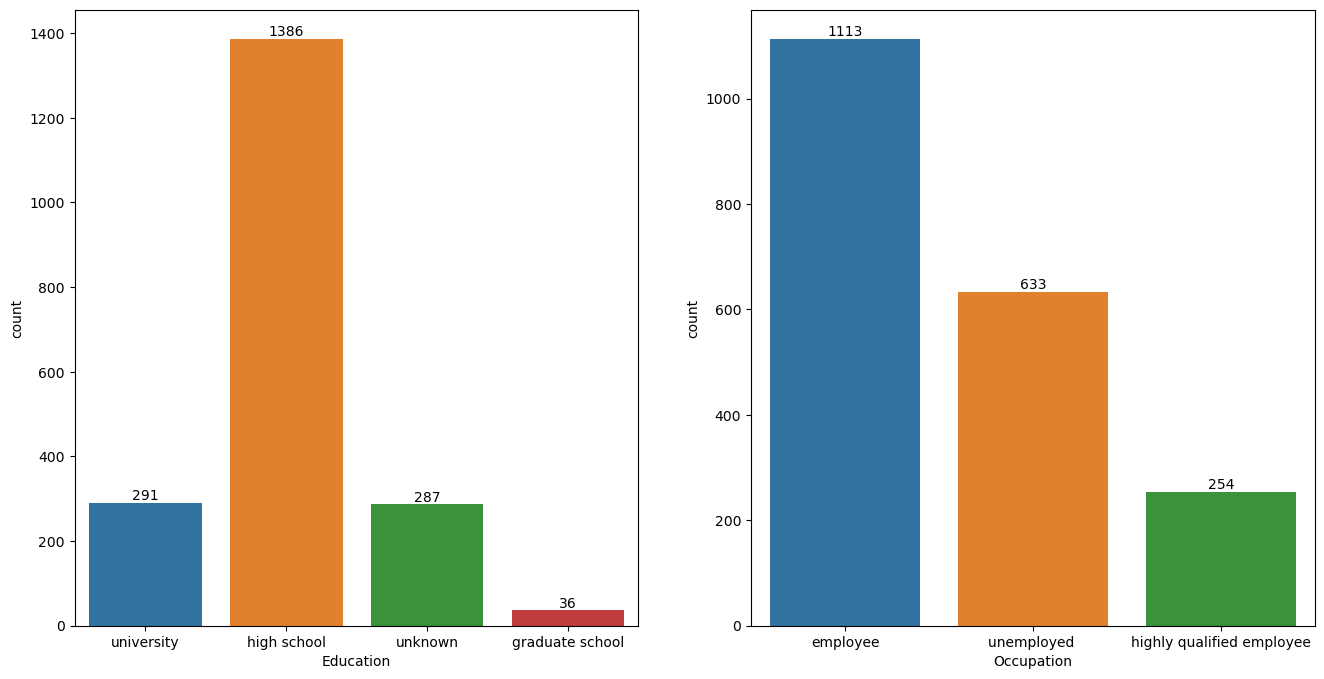

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))
sns.countplot(x='Education', data=data_view, ax = ax1)
ax1.bar_label(ax1.containers[0])

sns.countplot(x='Occupation', data=data_view, ax = ax2)
ax2.bar_label(ax2.containers[0])

plt.show()

Observando os gráficos nota-se que:

-  Cerca de 50% do dataset é composto por 'high school' e por 'employee'.
-  Menos de 2% das pessoas do dataset são 'graduate school'.
-  Cerca de 30% à 32% do dataset é composto por 'unemployed Occupation'..

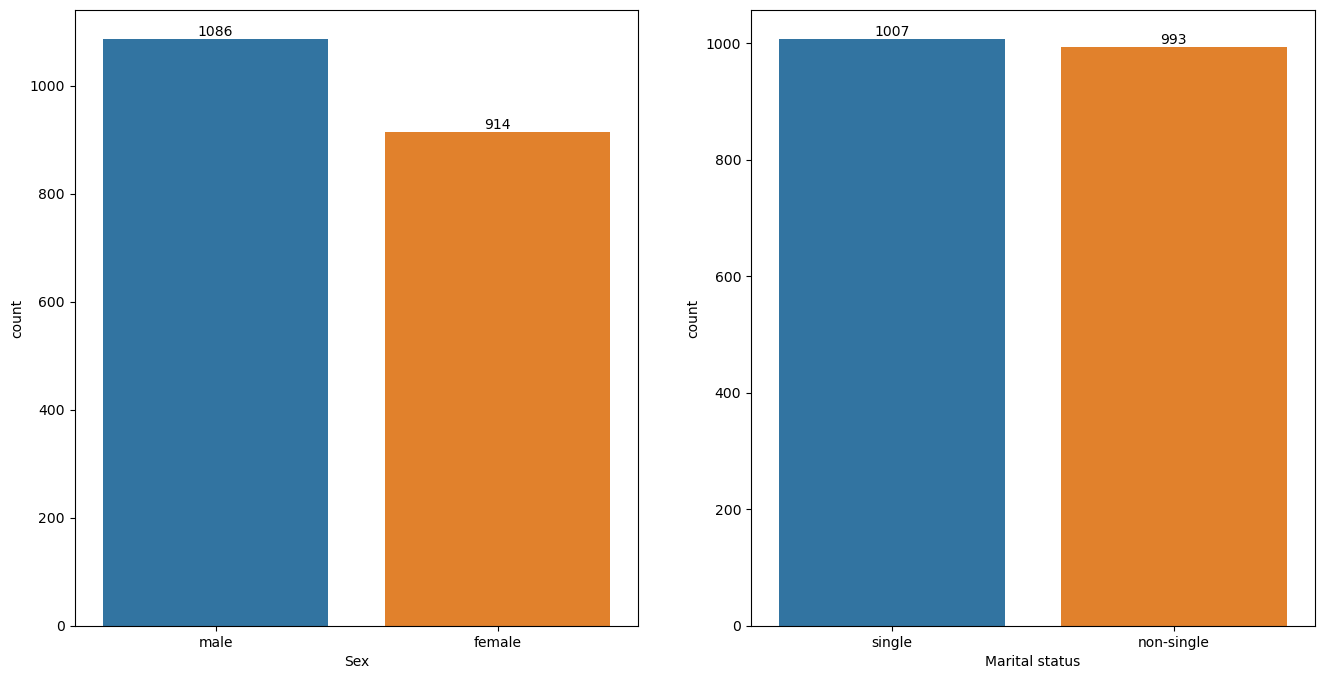

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))
sns.countplot(x='Sex', data=data_view, ax = ax1)
ax1.bar_label(ax1.containers[0])

sns.countplot(x='Marital status', data=data_view, ax = ax2)
ax2.bar_label(ax2.containers[0])

plt.show()

Analisando os gráficos têm-se:
- A quantidade de pessoas solteiras e não solteiras é praticamente igual neste dataset.
- A quantidade de pessoas do sexo 'male' e 'female' é relativamente igual, tendo uma diferença de cerca de 5% entre eles.

**Análise bi-variada**

In [15]:
def q25(x):
    return x.quantile(0.25)
def q50(x):
    return x.quantile(0.5)
def q75(x):
    return x.quantile(0.75)
def kurtosis_func(x):
    return kurtosis(x)
agg_functions = {'Income':['mean','std','min',q25,q50,q75,'max','skew',kurtosis_func]}
agg_functions2 = {'Age':['mean','std','min',q25,q50,q75,'max','skew',kurtosis_func]}

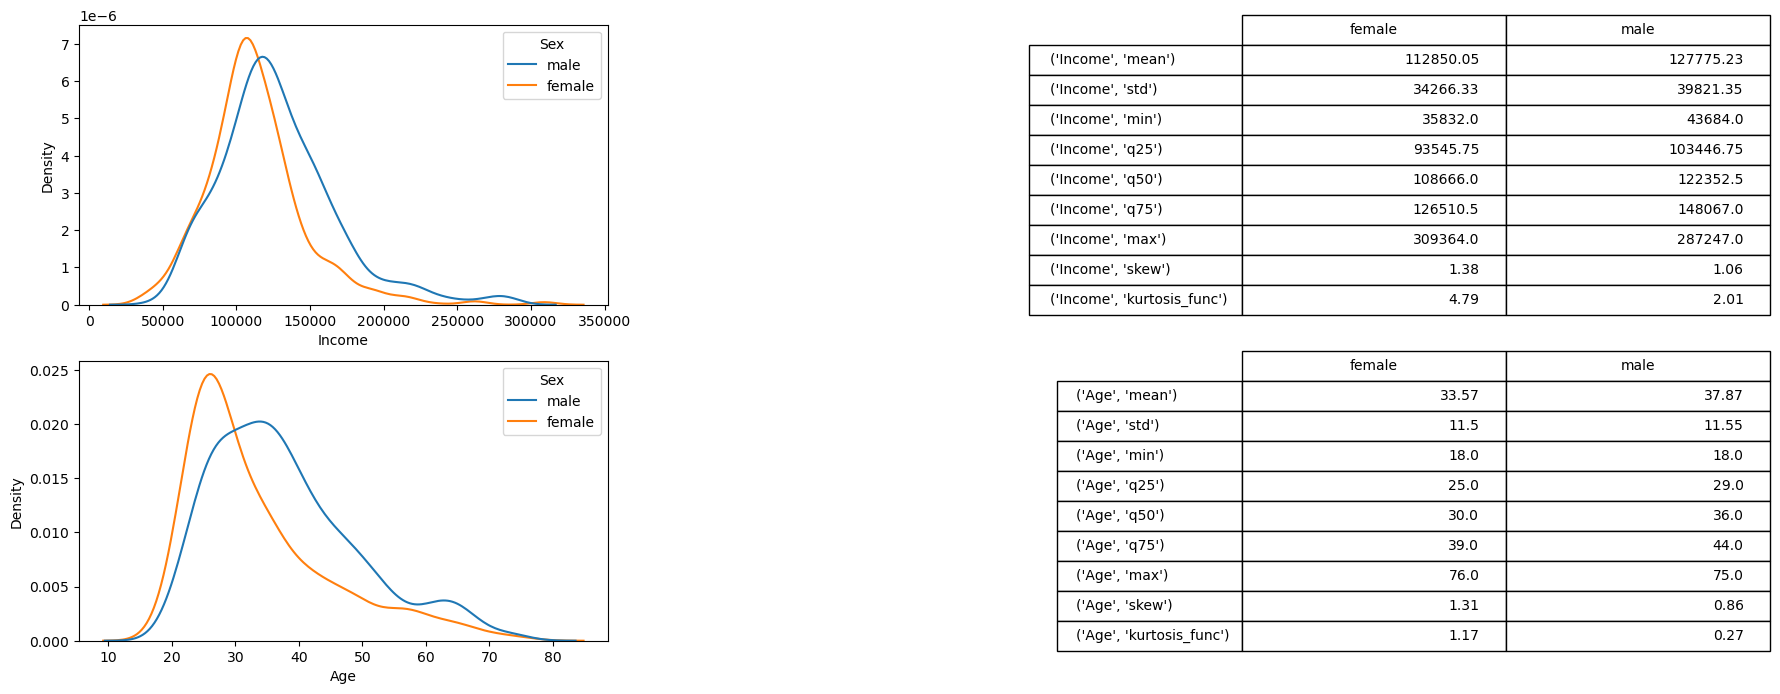

In [16]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15, 8))
sns.kdeplot(hue='Sex', x ='Income', data=data_view, ax = ax1)
aux = data_view.groupby(['Sex']).agg(agg_functions).T.round(2)
ax2.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax2.axis("off")  

sns.kdeplot(hue='Sex', x ='Age', data=data_view, ax = ax3)
aux = data_view.groupby(['Sex']).agg(agg_functions2).T.round(2)
ax4.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax4.axis("off") 

plt.show()

Observando os gráficos e as tabelas têm-se:
- A média de 'Income' do sexo 'male' é ligeiramente maior do que a do sexo 'female'.
- O valor mínimo de 'Income' e o desvio padrão do sexo 'female' são menores do que o sexo 'male', indicando uma distribuição mais concentrada.
- Os valores dos quartis (25%, 50% e 75%) para a classe 'female' são menores do que a classe 'male', resultando em valores esperados menores.
- A média de idades da classe 'male' é maior do que a da classe 'female'.
- A classe 'female' está mais concentrada na faixa dos 25 a 39 anos, enquanto a classe 'male' está concentrada entre os 29 e 44 anos.


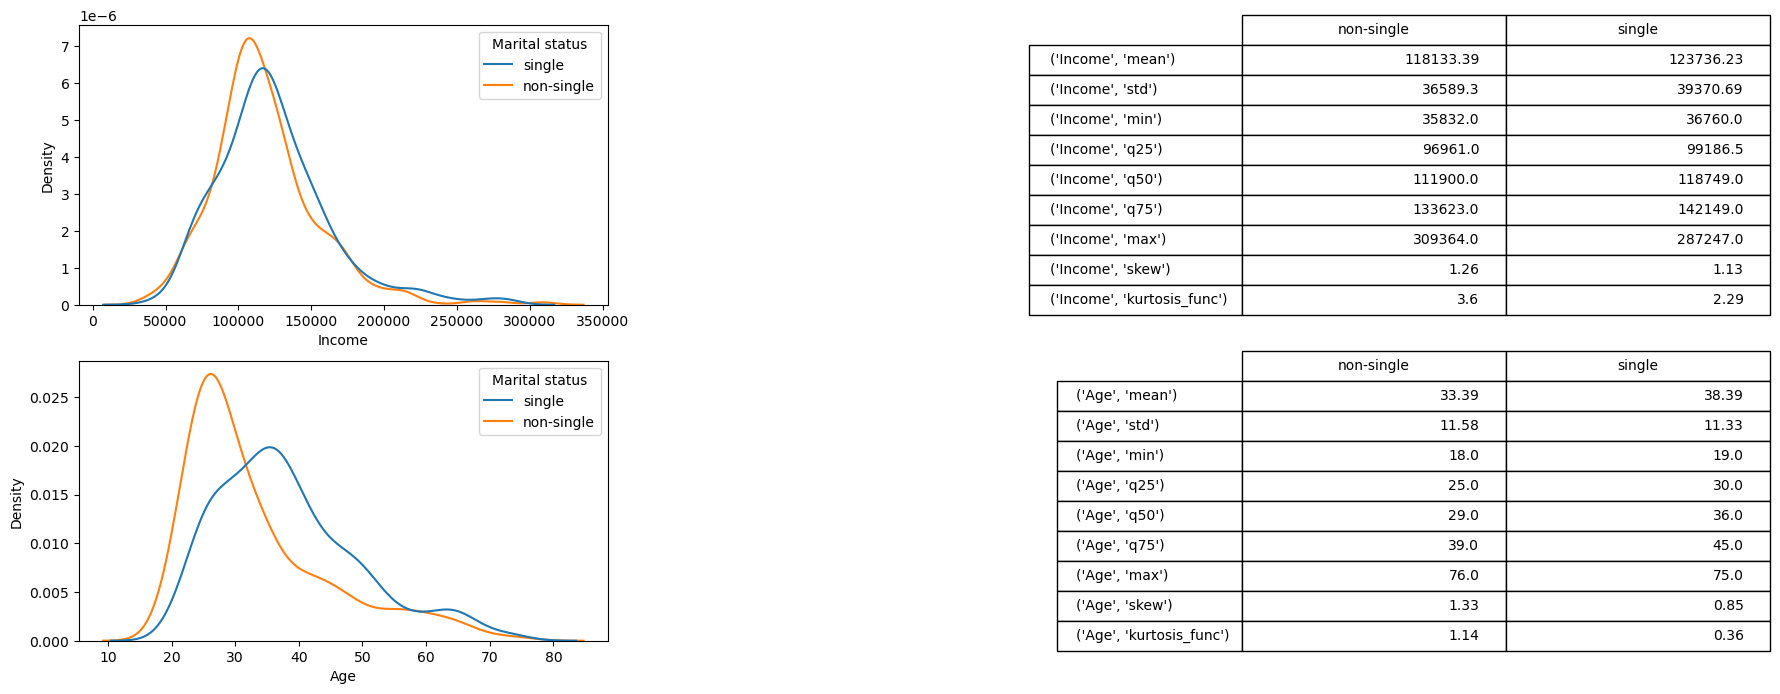

In [17]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15, 8))
sns.kdeplot(hue='Marital status', x ='Income', data=data_view, ax = ax1)
aux = data_view.groupby(['Marital status']).agg(agg_functions).T.round(2)
ax2.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax2.axis("off")  


sns.kdeplot(hue='Marital status', x ='Age', data=data_view, ax = ax3)
aux = data_view.groupby(['Marital status']).agg(agg_functions2).T.round(2)
ax4.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax4.axis("off")  

plt.show()

Observando os gráficos e as tabelas têm-se:
- A média de 'Income' para o 'single' é ligeiramente maior do que para o 'non-single'.
- Os valores de 'Income' para a categoria 'non-single' estão ligeiramente mais concentrados.
- Os valores dos quartis (25%, 50% e 75%) são bem próximos entre as duas classes.
- A média de idade da classe 'single' é maior do que a classe 'non-single'.
- A classe 'single' aparenta ter dados mais dispersos entre as faixas de 20 a 50 anos, enquanto a classe 'non-single' aparenta ter dados mais concentrados na faixa de 20 a 40 anos.

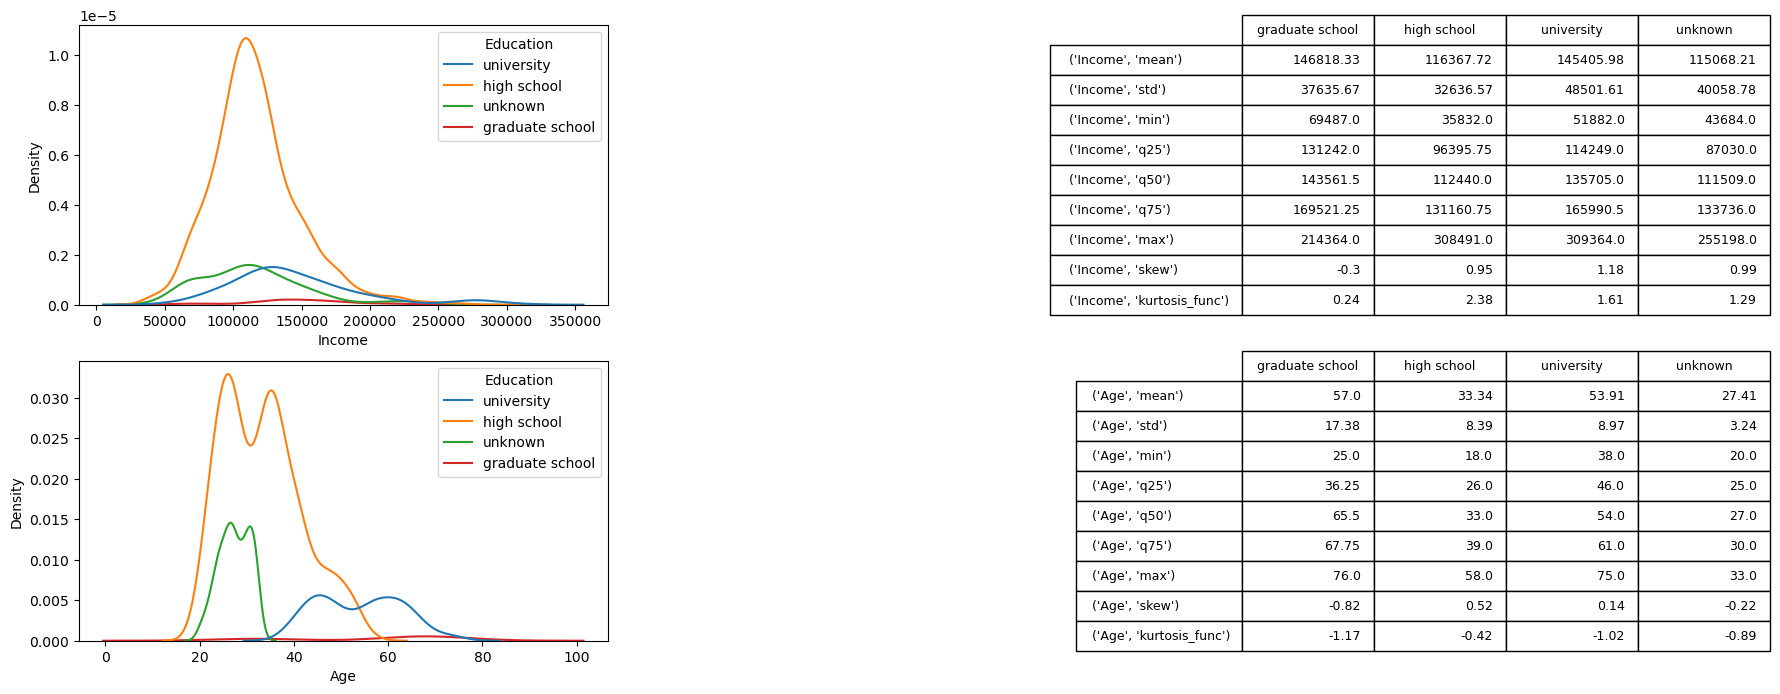

In [18]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15, 8))
sns.kdeplot(hue='Education', x ='Income', data=data_view, ax = ax1)
aux = data_view.groupby(['Education']).agg(agg_functions).T.round(2)
ax2.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax2.axis("off")  

sns.kdeplot(hue='Education', x ='Age', data=data_view, ax = ax3)
aux = data_view.groupby(['Education']).agg(agg_functions2).T.round(2)
ax4.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax4.axis("off")  


plt.show()

Observando os gráficos e as tabelas nota-se:
- A média de income das classes 'graduate school' e 'university' são próximas e maiores que as classes 'high school' e 'unknown'.
- A classe 'graduate school' possui uma curtose muito baixa, indicando que seus dados estão muito pulverizados. Isso indica que sua média e demais medidas não são representativas.
- Observando a tabela, nota-se que as métricas da classe 'high school' e 'unknown' são bem próximas e similares. Isto indica que a maioria dos dados da classe 'unknown' podem pertencer a classe 'high school'.
- As classes 'unknown', 'high school' e 'university' aparentam ter dois pontos de concentração em cada uma das distribuições.
- As classes 'unknown' e 'high school' possuem distribuições de idades mais jovens, possuindo média de idades menores, enquanto as classes 'university' e 'graduate school' possuem idades mais avançadas, possuindo médias de 57 e 54 anos.
- A menor idade da classe 'university' é de 38 anos.
- A maior idade da classe 'unknown' é de 33 anos.

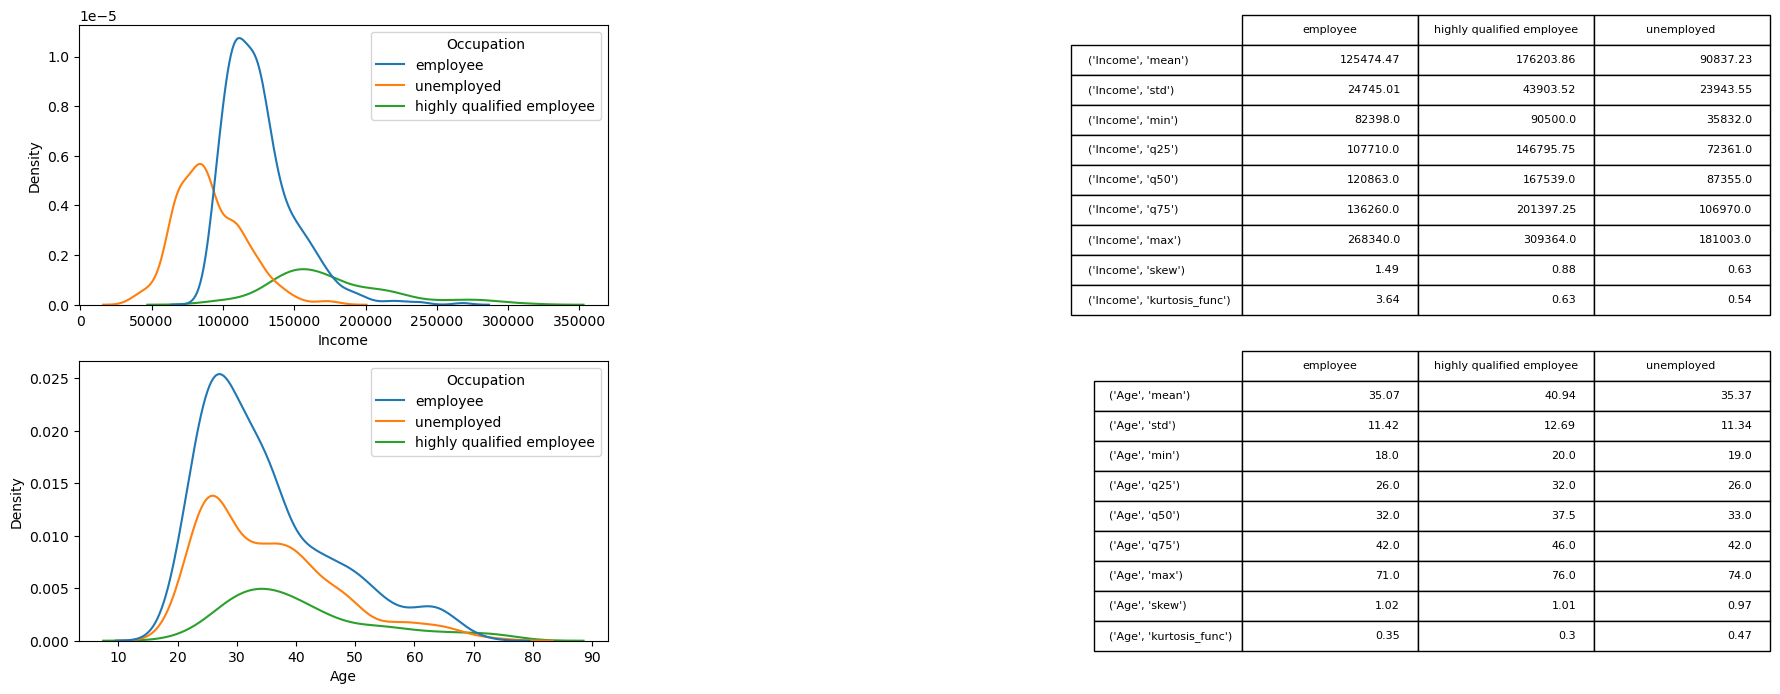

In [19]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15, 8))
sns.kdeplot(hue='Occupation', x ='Income', data=data_view, ax = ax1)
aux = data_view.groupby(['Occupation']).agg(agg_functions).T.round(2)
ax2.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax2.axis("off")  

sns.kdeplot(hue='Occupation', x ='Age', data=data_view, ax = ax3)
aux = data_view.groupby(['Occupation']).agg(agg_functions2).T.round(2)
ax4.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax4.axis("off")  

plt.show()

Observando as tabelas e os gráficos nota-se:
- A média, os quartis e o desvio padrão da classe 'unemployed' são menores do que as demais classes.
- Pelo gráfico nota-se que a classe 'employee' possui valores bem concentrados em torno da mediana e da média.
- A classe 'highly qualified employee' possui uma média maior que as demais classes, porém possui um desvio padrão bem maior que as outras, indicando que os valores de 'Income' são bem dispersos.
- As distribuições de idade da classe 'employee' e 'unemployed' são similares.
- A classe 'highly qualified employee' possui uma média de idades maior que as demais classes.
- Na classe 'unemployed' observa-se duas concentrações de valores, uma próxima dos 25 anos e outra próxima dos 40 anos.

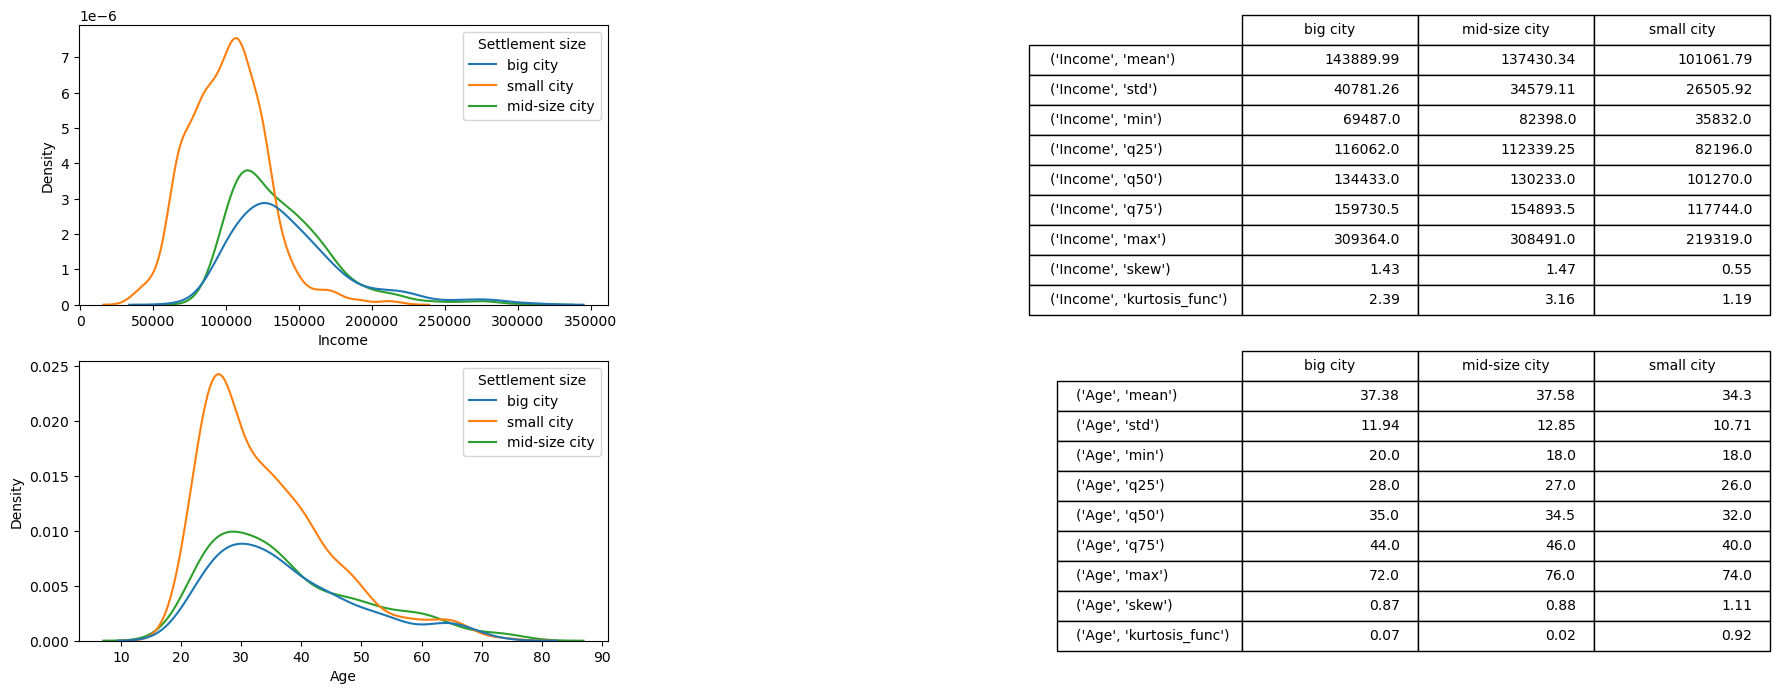

In [20]:
fig,((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15, 8))
sns.kdeplot(hue='Settlement size', x ='Income', data=data_view, ax = ax1)
aux = data_view.groupby(['Settlement size']).agg(agg_functions).T.round(2)
ax2.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax2.axis("off")  

sns.kdeplot(hue='Settlement size', x ='Age', data=data_view, ax = ax3)
aux = data_view.groupby(['Settlement size']).agg(agg_functions2).T.round(2)
ax4.table(cellText= aux.values, colLabels=aux.columns, rowLabels= aux.index, loc = 'right').scale(1, 1.8)
ax4.axis("off") 


plt.show()

Pelos gráficos e as tabelas é possivel observar:
- As distribuições de 'big city' e 'mid-size city' são muito similares.
- A média e desvio padrão da classe 'small city' é menor do que as demais classes.
- As três classes possuem distribuição de idades similares, tendo uma pequena diferença da média para a classe 'small city', que possui um valor menor.

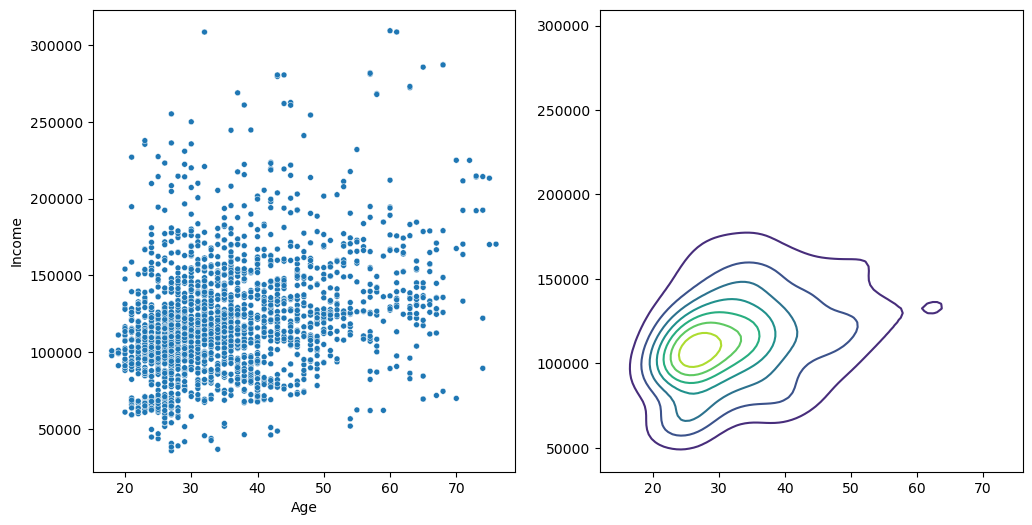

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12, 6))

def density_estimation(m1, m2):
    X, Y = np.mgrid[m1.min()-6:m1.max():100j, m2.min():m2.max():100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

X,Y,Z = density_estimation(data_view['Age'], data_view['Income'])


sns.scatterplot(data = data_view, x = 'Age', y = 'Income', size= 0.2, ax = ax1, legend = False)
ax2.contour(X, Y, Z)


plt.show()

Pelos gráficos é possível observar:
- Existe uma relação de linearidade entre 'Age' e 'Income' crescente.
- Existe uma concentração de dados entre a faixa de 'Age' entre 25 a 30 anos e de 'Income' entre 100,000 e 130,000.
- Existem outliers após a faixa de 200,000 de 'Income'.

**<h3> Correlation data**

Visando evitar possíveis problemas de multicolinearidade na resolução do problema será utilizado o método de correlação de Pearson, visando identificar a correlação linear entre as variáveis.

Como valor de corte será utilizado o valor de 0.75 e de -0.75, sendo esses valores definidos empiricamente em projetos anteriores.

<AxesSubplot:>

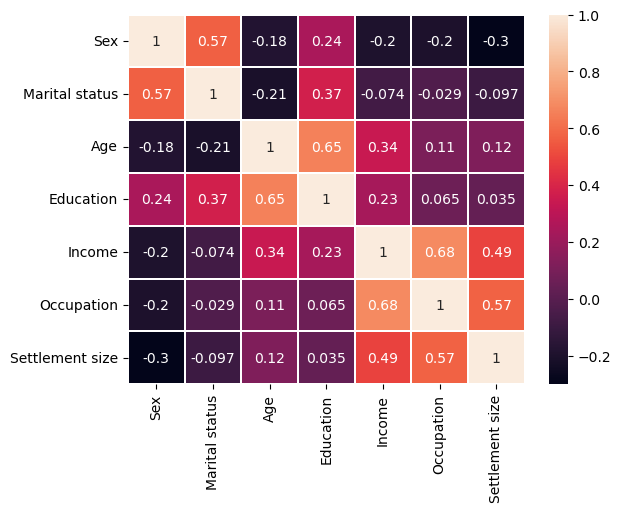

In [22]:
data.drop('ID', axis=1, inplace = True)
pearson_matrix = data.corr(method='pearson')
sns.heatmap(pearson_matrix, annot=True,linewidths=.1)

Como nenhuma variável ultrapassou os valores de corte nenhuma variável será removida e/ou modificada.

**<h1> Feature Engerring**

**Scaling data**

Como o objetivo do projeto é a elaboração de grupos de clientes-alvos será adotado o modelo de clusterização por meio do modelo K-means para a identificação destes grupos.

Por ser tratar de um modelo de clusterização baseado em distâncias euclidianas, os dados devem ser escalonados para que o modelo utilizado tenha maior precisão na geração dos grupos. Portanto será aplicado uma transformação 'MinMaxScaler', onde o cálculo da reescala é feito de forma independente entre cada coluna, de tal forma que a nova escala se dará entre 0 e 1 (ou -1 e 1 se houver valores negativos no dataset).

Como as variáveis 'Education', 'Occupation' e 'Settlement size' são variáveis categóricas e ordinais (possuem uma hierarquia definida) não será realizado nenhum procedimento de enconding nessas variáveis.

In [23]:
# Escalonando as variáveis
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaler = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_scaler.head()

Sex  Marital status       Age  Education    Income  Occupation  \
0  0.0             0.0  0.844828   0.666667  0.324781         0.5   
1  1.0             1.0  0.068966   0.333333  0.420210         0.5   
2  0.0             0.0  0.534483   0.333333  0.195144         0.0   
3  0.0             0.0  0.465517   0.333333  0.496223         0.5   
4  0.0             0.0  0.603448   0.333333  0.413842         0.5   

   Settlement size  
0              1.0  
1              1.0  
2              0.0  
3              0.5  
4              0.5

**<h1> Model implementation <h5>**
<h3> K - Means

Para a implementação do modelo k-means inicialmente deve ser estipulado a quantidade de grupos a serem gerados pelo algoritmo. Para isto será utilizado dois critérios diferentes para identificar esta quantidade de clusters. Os critérios utilizados serão:
- The Elbow method (baseado na inércia).
- Critério de Calinski and Harabasz.



O 'Elbow method' ou 'método do cotovelo' é um método para definir a quantidade de clusters baseado no erro gerado por cada grupo. neste método o objetivo não é selecionar o menor erro, mas sim a quantidade de clusters que a partir dele não ocorre variação significativa do erro. Com base nisso, a avaliação deste método é feita graficamente, relacionando o erro gerado e a quantidade de clusters, visando identificar esse ponto de inflexão onde o erro não diminui significativamente.

O critério 'Calinski and Harabasz' é um método que leva em consideração do quão semelhante um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Aqui, a coesão é estimada com base nas distâncias dos pontos de dados em um cluster ao centróide do cluster e a separação é baseada na distância dos centróides do cluster ao centróide global. Ele também é avaliado graficamente e valor mais alto desse método significa que os clusters são densos e bem separados, embora não exista um valor de corte “aceitável”. Precisamos escolher aquela solução que fornece um pico ou pelo menos uma curva abrupta no gráfico linear.

In [24]:
# Avaliando o número de clusters utilizados no K-means
wcss = []
CeH = []
for i in range(2,10):
    kmeans_1 = KMeans(n_clusters = i, random_state = 0)
    kmeans_1.fit(data_scaler)
    # Calculando as métricas
    aux2 = calinski_harabasz_score(data_scaler, kmeans_1.labels_)
    # Armazenando os valores das métricas calculadas
    wcss.append(kmeans_1.inertia_)
    CeH.append(aux2)

In [25]:
# Criando os gráficos das métricas

figu = make_subplots(rows = 2, cols = 1,subplot_titles=("Elbow method", "Calinski and Harabasz"))
# Add traces
X = np.arange(2,21)
figu.add_trace(
    go.Scatter(x = X, y = wcss,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=1,col=1)
figu.add_trace(
    go.Scatter(x = X, y = CeH,mode='lines+markers',line={'color' : 'blue'}, marker = {'color' : 'black'}),
    row=2,col=1)

# Update xaxis properties
figu.update_xaxes(title_text="Nº clusters", row=1, col=1)
figu.update_xaxes(title_text="Nº clusters", row=2, col=1)

# Update yaxis properties
figu.update_yaxes(title_text="Score", row=1, col=1)
figu.update_yaxes(title_text="Score", row=2, col=1)
figu.update_layout(showlegend=False,height=1000, width=1000)
figu.show()

Observando os gráficos tem-se que:
- Para o método do cotovelo não ocorre um ponto de inflexão muito perceptível, tendo uma ligeira alteração nas curvas com 4 e 6 clusters.
- Para o critério de Calinski and Harabasz o primeiro ponto de inflexão positivo ocorre com número de clusters igual à 6.

Como o critério de Calinski and Harabasz apresentou um valor plausível, será utilizado 6 clusters para o resto das análises.

<h3> Cluster vizualization - PCA 

Após o processo de clusterização é necessário a realização de uma verificação visual e analítica sobre os grupos gerados, visto que essa é uma técnica de aprendizado não supervisionada. Para isso, pode-se utilizar as próprias variáveis do dataset para tentar realizar a visualização e entendimento desses clusters, porém é complexo identificar quais seriam as principais variáveis a serem utilizadas neste processo.

Com o intuito de ter uma melhor explicabilidade dos clusters gerados, será utilizado a técnica do 'PCA' (Análise dos Componentes Principais). Esta técnica tem como objetivo a redução de dimensionalidade (quantidade de variáveis) de um dataset por meio da criação de novas variáveis que expliquem de maneira satisfatória os dados originais. 

Portanto, a utilização desta técnica tem como objetivo criar novas dimensões para uma melhor visualização dos clusters gerados

In [26]:
pca = PCA()
pca_components = pca.fit(data_scaler)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
var_cumulative = np.zeros(len(var))
var_cumulative[0] = var[0]
for i in range(1,len(var)):
    var_cumulative[i] = var[i]+var_cumulative[i-1]

labels = [
    f"PC {i+1}"
    for i in range(0,len(var))
]

fig = go.Figure()
fig.add_trace(go.Bar(
    x = labels,
    y= var,
    text = var,
    name='Individual contribution'))

fig.add_trace(go.Bar(
    x = labels,
    y = var_cumulative,
    text = var_cumulative,
    name ='Cumulative contribution'))

fig.update_layout(barmode='group',
                  title="PCA Explained contribution",
                  xaxis_title="Components",
                  yaxis_title="Value of Contribution")

fig.show()

Observando o gráfico nota-se que a explicabilidade dos dados com três componentes é de 84,3% sendo um valor que eu considero razoável para a visualização dos dados.

In [27]:
kmeans_customer = KMeans(n_clusters = 6, random_state = 0)
kmeans_customer.fit(data_scaler)
data['class'] = kmeans_customer.labels_
for i in range(0,max(kmeans_customer.labels_)+1):
    var = 'class '+ str(i+1)
    data['class'] = data['class'].replace(i,var)
data_view['class'] = data['class']

In [28]:
pca = PCA(3)
pca_components=pca.fit(data_scaler)
scores_pca = pca.transform(data_scaler)
pca_data = pd.DataFrame(scores_pca, columns=['PC 1','PC 2','PC 3']) 
pca_data['class'] = data['class']

fig = px.scatter_3d(pca_data,x = 'PC 1', y = 'PC 2', z = 'PC 3' ,color='class',width=1200,height = 600, labels={"class":"Classified class"})
fig.update_traces(marker_size = 4)
fig.show()

Analisando o gráfico gerado tem-se que as classes 1 e 4 estão bem isoladas podendo representar grupos distintos de clientes-alvo.

Já as classes 6 e 3 aparentam estar muito próximas, necessitando verificar se estes grupos realmente possuem características diferentes entre eles. O mesmo problema acontece com as classes 2 e 5, necessitando também serem analisados.

**Analisando os Clusters 3 e 6**

In [29]:
cond = (data_view['class']== 'class 3') | (data_view['class']== 'class 6')
df_view = data_view.loc[cond].copy()

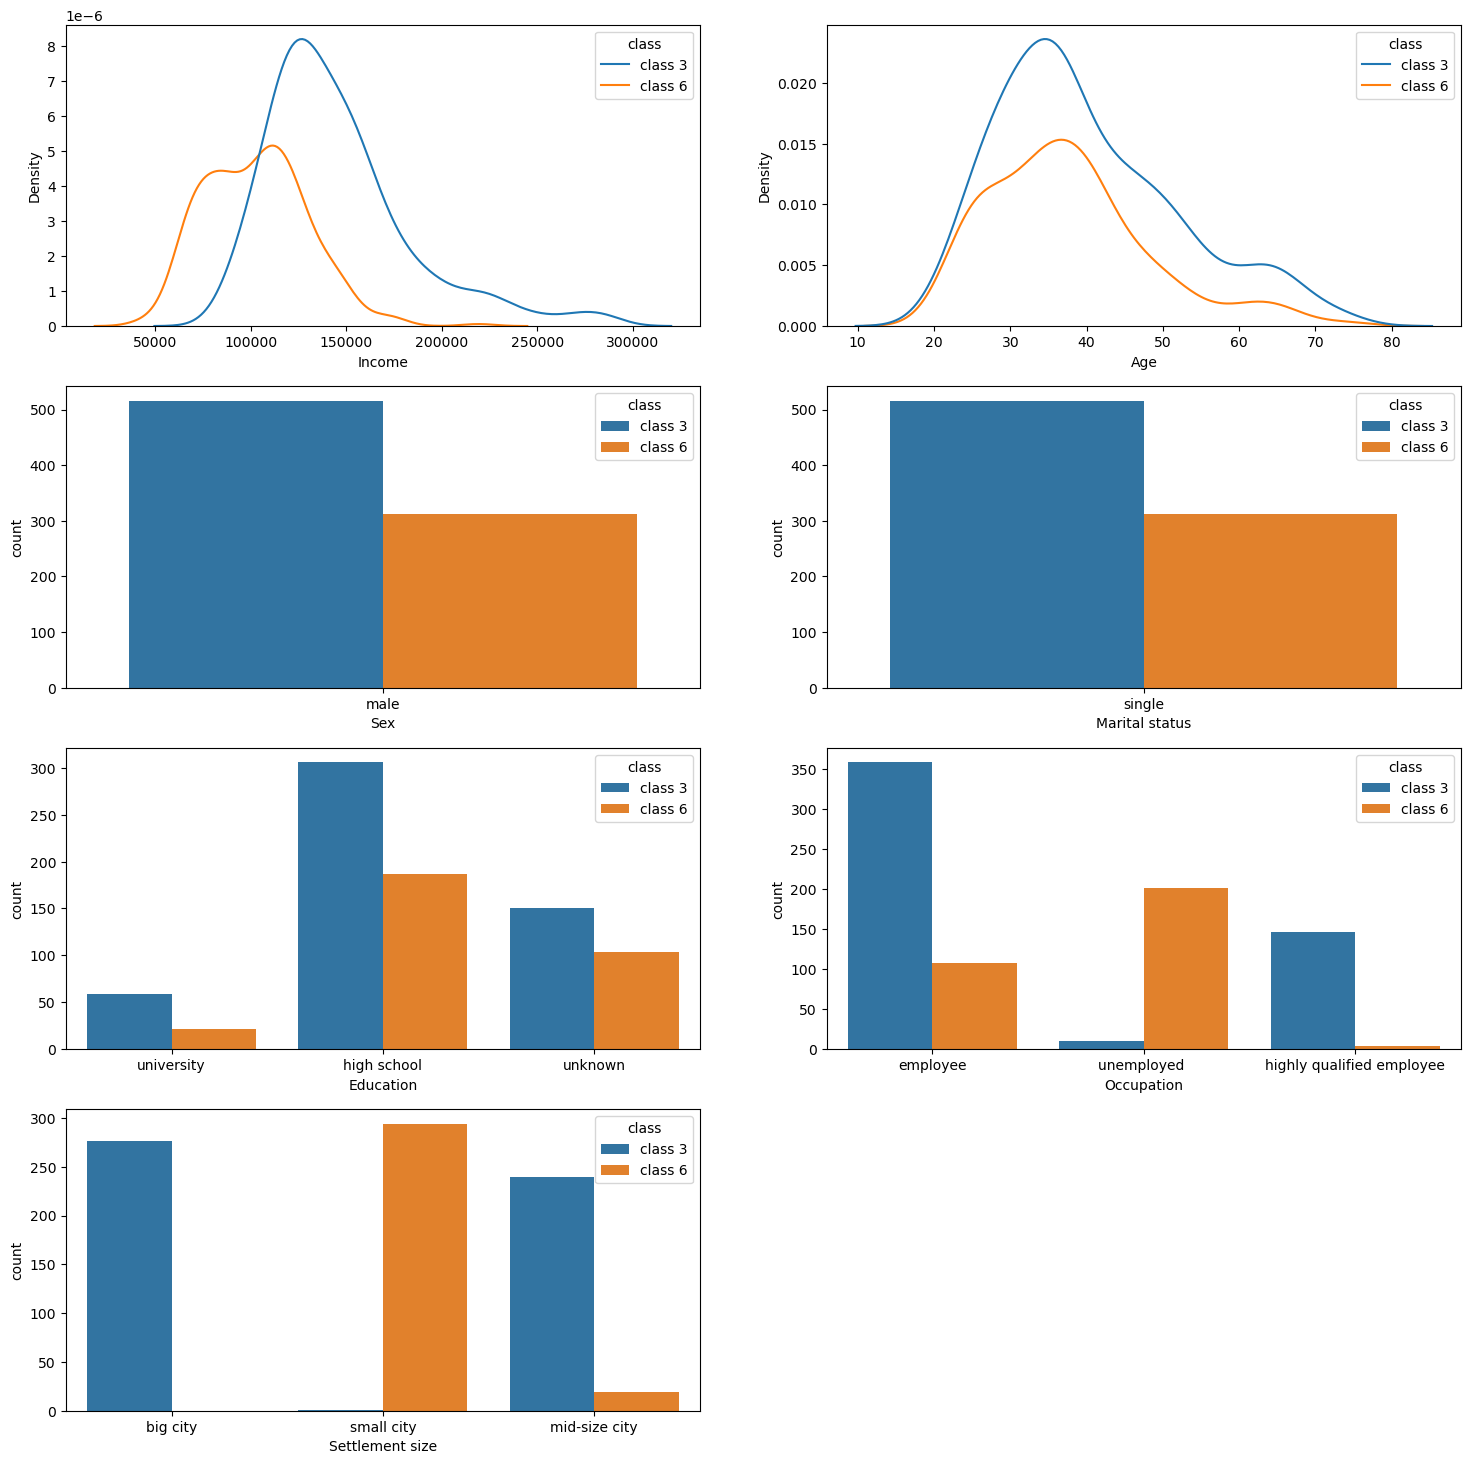

In [30]:
fig, ((ax1,ax5),(ax2,ax6),(ax3,ax7),(ax4,ax8)) = plt.subplots(4,2,figsize=(18, 18))

sns.kdeplot(hue='class', x ='Income', data=df_view, ax = ax1)
sns.kdeplot(hue='class', x ='Age', data=df_view, ax = ax5)

sns.countplot(x='Sex',hue='class', data=df_view, ax = ax2)
sns.countplot(x='Marital status',hue='class', data=df_view, ax = ax6)

sns.countplot(x='Education',hue='class', data=df_view, ax = ax3)
sns.countplot(x='Occupation',hue='class', data=df_view, ax = ax7)


sns.countplot(x='Settlement size',hue='class', data=df_view, ax = ax4)
ax8.axis("off") 
plt.show()

Nota-se pelos gráficos que:
- Ambos os clusters (3 e 6) são compostos unicamente pela classe 'male' na variável 'Sex' e pela classe 'single' pela variável 'Marital status'. Isto pode indicar que essas duas variáveis tiveram grande impacto na elaboração do modelo de clusterização.
- O cluster 3 é composto majoritariamente pelas classes 'big city' e 'mid-size city' na variável 'Settlement size', já o cluster 6 é composto majoritariamente pela classe 'small city' com alguns poucos dados de 'mid-size city'.
- Nota-se que o cluster 6 quase não possui dados da classe 'highly qualified employee' para a variável 'Occupation' e é composto em sua maior parte por 'unemployed'. Em comparação o cluster 3 é o oposto, havendo uma parcela maior de dados de 'highly qualified employee' e poucos de 'unemployed'.
- Existe uma diferença de renda entre os dois clusters, sendo o cluster 3 mais concentrado em torno de 130,000 a 140,000 enquanto o cluster 6 está na faixa dos 70,000 e 120,000.
- Não existe uma diferença de distribuição de idades entre os dois clusters.

Por fim, os dois clusters algumas similaridades, mas têm diferenças bem significativas, sendo o cluster 6 um agrupamento de homens solteiros com menor renda e de empregos de menor grau hierárquico e que moram majoritariamente em cidades pequenas, enquanto o cluster 3 um agrupamento de homens solteiros com uma renda maior e de empregos de maior grau hierárquico e que moram em cidades de médio/grande porte.


**Analisando os Clusters 2 e 5**

In [31]:
cond = (data_view['class']== 'class 2') | (data_view['class']== 'class 5')
df_view2 = data_view.loc[cond].copy()

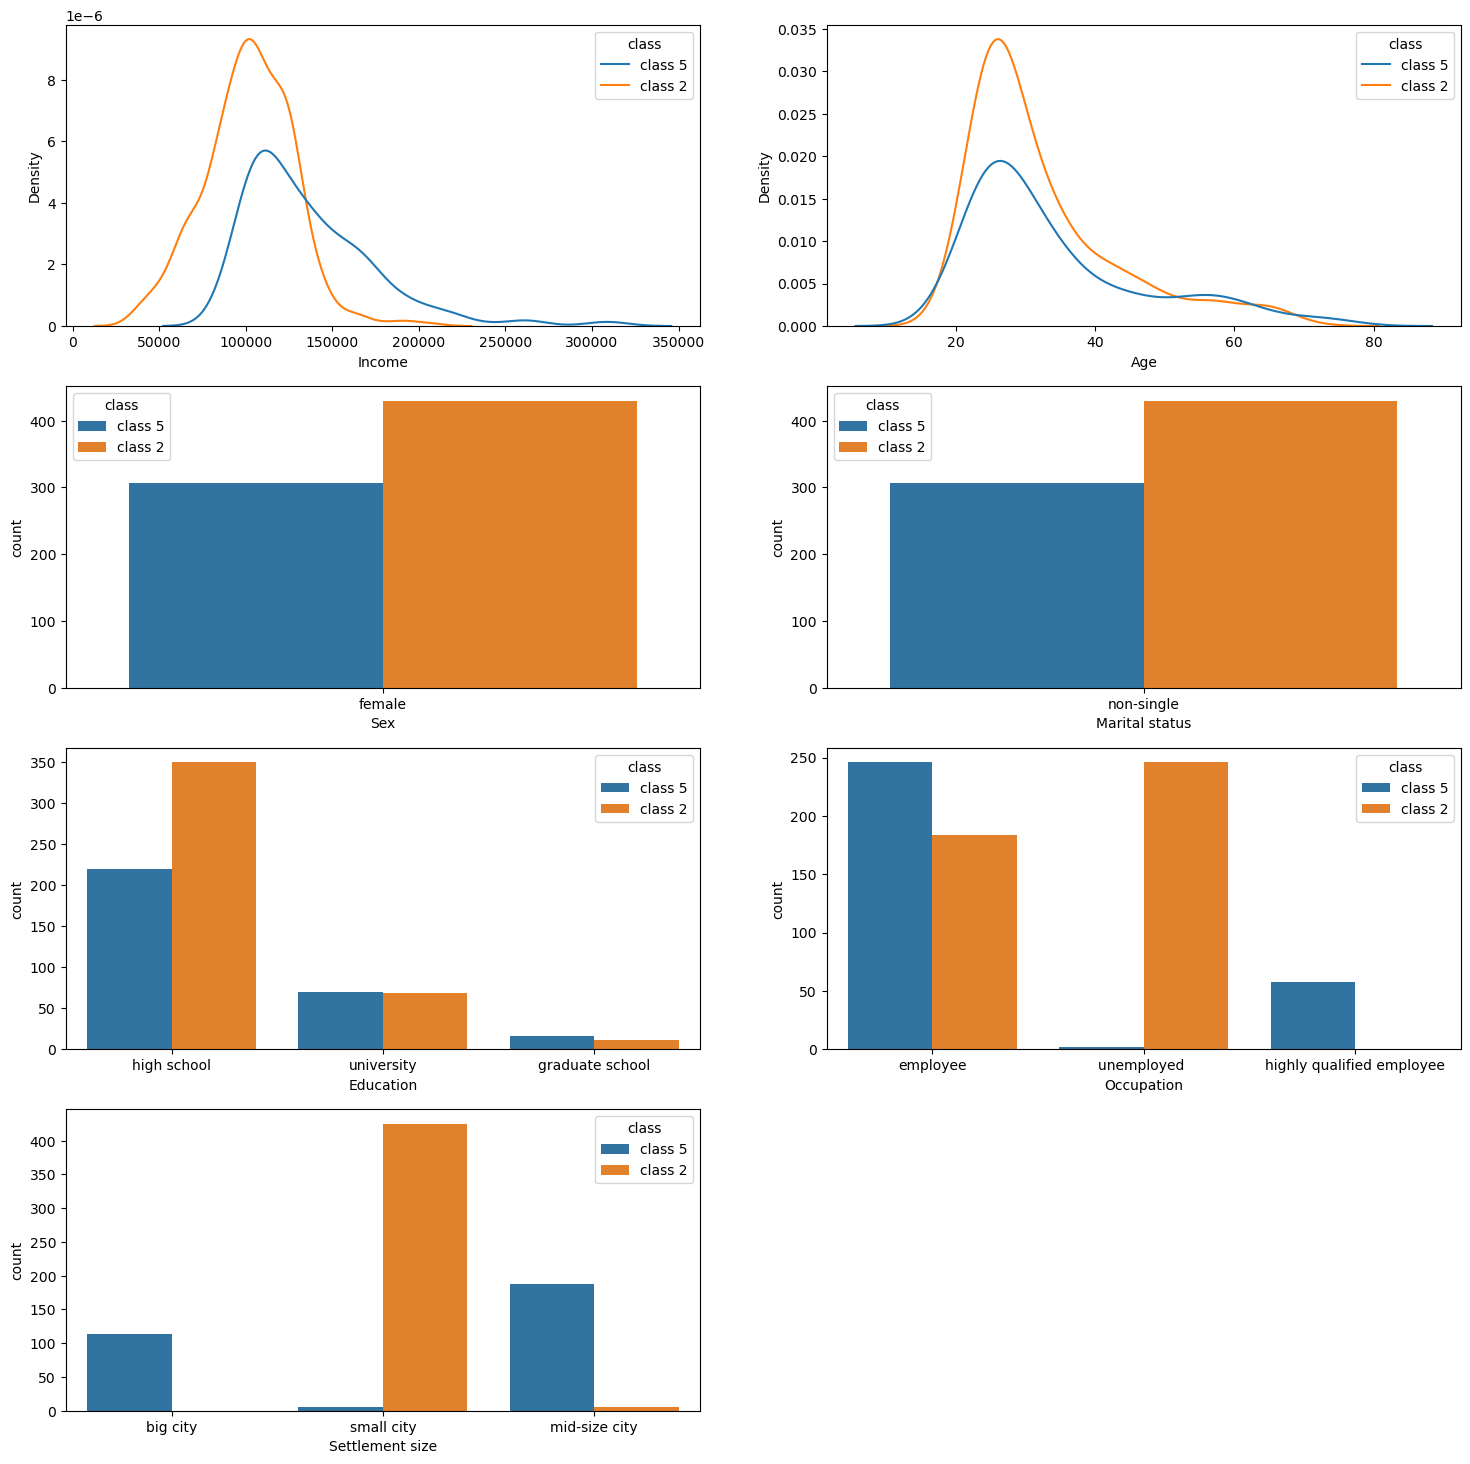

In [32]:
fig, ((ax1,ax5),(ax2,ax6),(ax3,ax7),(ax4,ax8)) = plt.subplots(4,2,figsize=(18, 18))

sns.kdeplot(hue='class', x ='Income', data=df_view2, ax = ax1)
sns.kdeplot(hue='class', x ='Age', data=df_view2, ax = ax5)

sns.countplot(x='Sex',hue='class', data=df_view2, ax = ax2)
sns.countplot(x='Marital status',hue='class', data=df_view2, ax = ax6)

sns.countplot(x='Education',hue='class', data=df_view2, ax = ax3)
sns.countplot(x='Occupation',hue='class', data=df_view2, ax = ax7)


sns.countplot(x='Settlement size',hue='class', data=df_view2, ax = ax4)
ax8.axis("off") 
plt.show()

Nota-se pelos gráficos que:
- Ambos os clusters (2 e 5) são compostos unicamente pela classe 'female' na variável 'Sex' e pela classe 'non-single' pela variável 'Marital status'.
- O cluster 5 é composto majoritariamente pelas classes 'big city' e 'mid-size city' na variável 'Settlement size', já o cluster 2 é composto majoritariamente pela classe 'small city'.
- Nota-se que o cluster 2 quase não possui dados da classe 'highly qualified employee' para a variável 'Occupation' e é composto em sua maior parte por 'unemployed'. Em comparação o cluster 5 é o oposto, havendo uma parcela maior de dados de 'highly qualified employee' e quase nenhum da classe 'unemployed'.
- Não existe uma diferença de renda visível, mas o cluster 5 possui uma maior variabilidade de renda, enquanto o cluster 2 apresenta dados concentrados em torno do valor de 100,000.
- Não existe uma diferença de distribuição de idades entre os dois clusters.

Da mesma forma que ocorreu entre os clusters 6 e 3 ocorreu entre os clusters 5 e 2, sendo o cluster 2 um agrupamento de mulheres 'non-single’ de empregos de menor grau hierárquico e que moram majoritariamente em cidades pequenas, enquanto o cluster 5 é um agrupamento de mulheres 'non-single’ de empregos de maior grau hierárquico e que moram em cidades de médio/grande porte.

**Analisando os Clusters 1 e 4**

In [33]:
cond = (data_view['class']== 'class 1') | (data_view['class']== 'class 4')
df_view3 = data_view.loc[cond].copy()

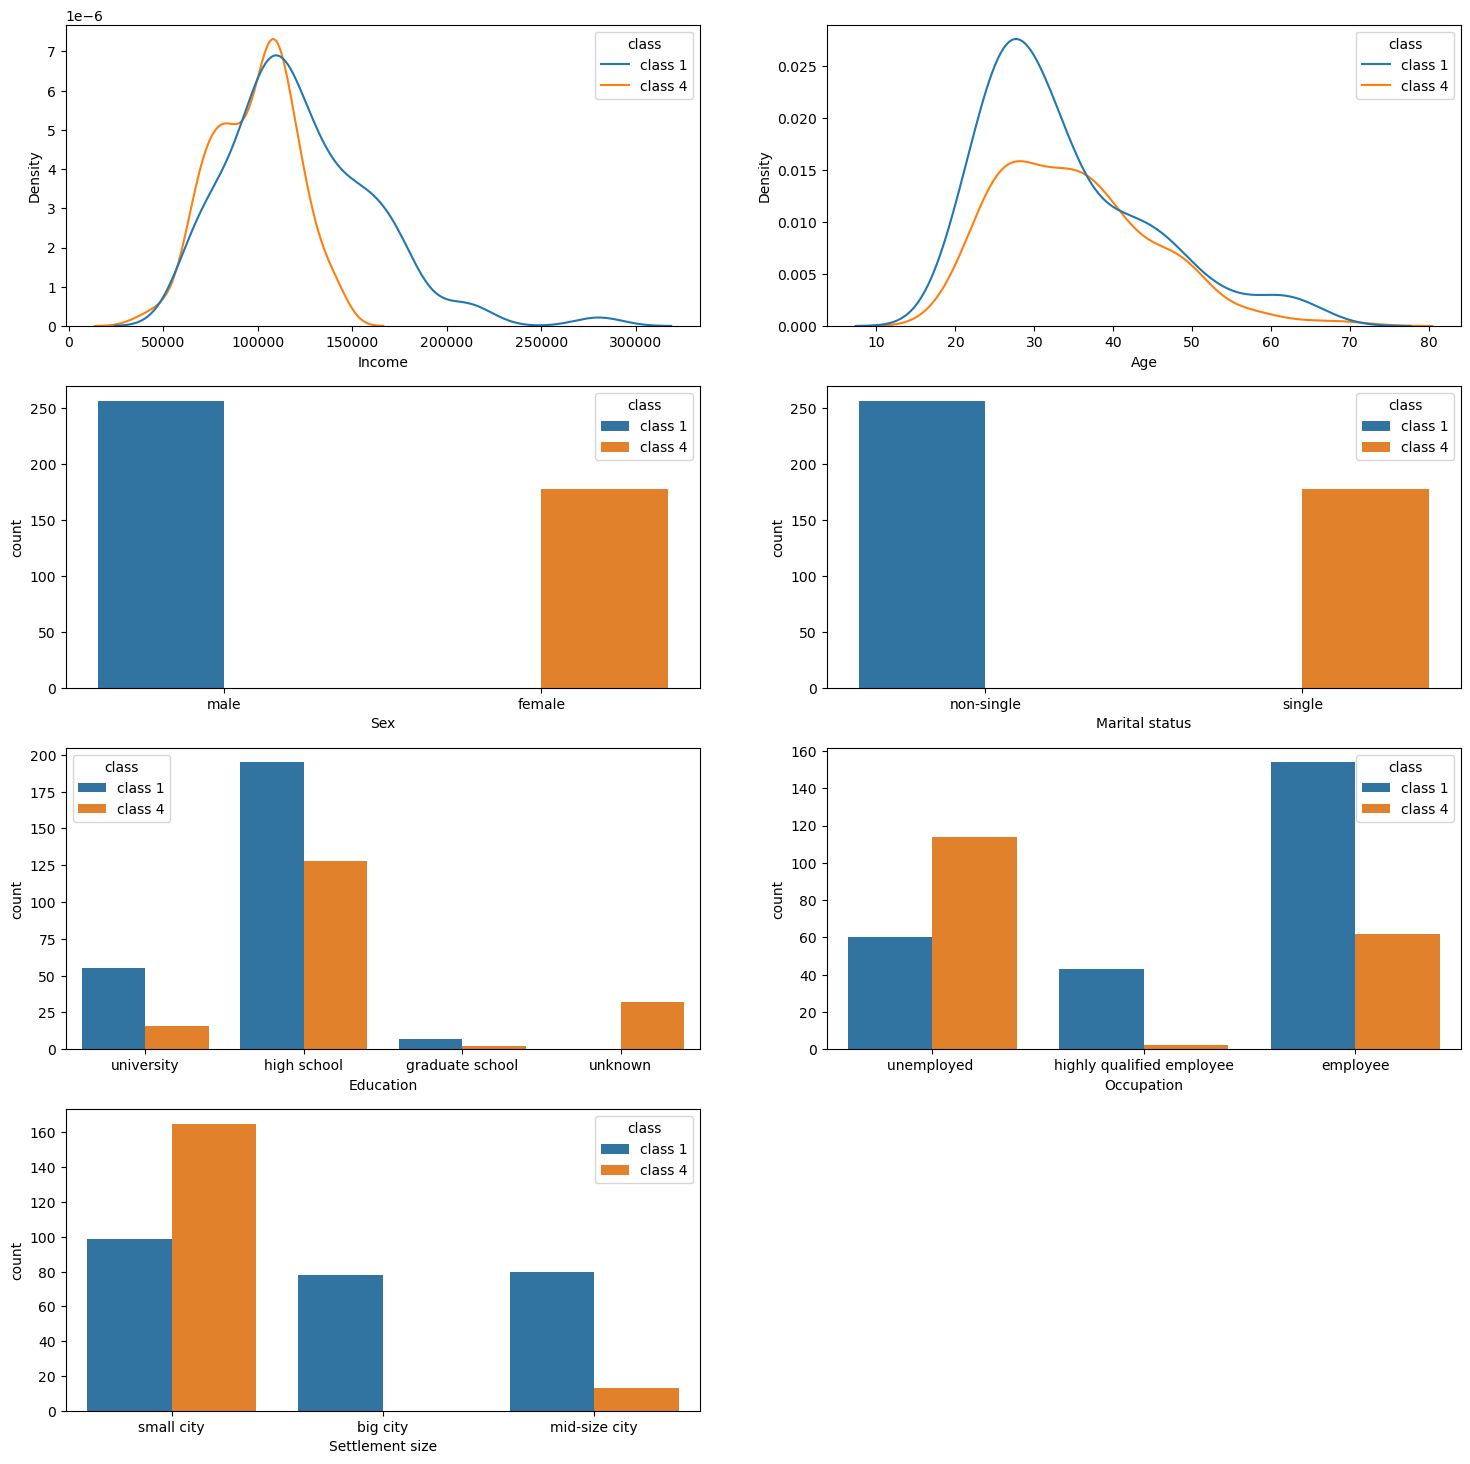

In [34]:
fig, ((ax1,ax5),(ax2,ax6),(ax3,ax7),(ax4,ax8)) = plt.subplots(4,2,figsize=(18, 18))

sns.kdeplot(hue='class', x ='Income', data=df_view3, ax = ax1)
sns.kdeplot(hue='class', x ='Age', data=df_view3, ax = ax5)

sns.countplot(x='Sex',hue='class', data=df_view3, ax = ax2)
sns.countplot(x='Marital status',hue='class', data=df_view3, ax = ax6)

sns.countplot(x='Education',hue='class', data=df_view3, ax = ax3)
sns.countplot(x='Occupation',hue='class', data=df_view3, ax = ax7)


sns.countplot(x='Settlement size',hue='class', data=df_view3, ax = ax4)
ax8.axis("off") 
plt.show()

Examinando os clusters 1 e 4 temos:
- O cluster 1 é composto pela classe 'male' da variável 'Sex' e pela classe 'non-single' da variável 'Marital status'.
- O cluster 4 é composto pela classe 'female' da variável 'Sex' e pela classe 'single' da variável 'Marital status'.
- O cluster 4 não apresenta dados de pessoas da classe 'highly qualified employee' da variável 'Occupation', pessoas da classe 'big city' da variável 'Settlement size'. Este cluster tem 'Income' menores que 150,000, sendo a maioria das rendas concentradas em torno de 100,000.
- O cluster 1 é bem diversificado, tendo a mesma proporção de dados para todas as classes da variável 'Settlement size' e possui uma parcela dados da classe 'highly qualified employee' da variável 'Occupation'. A maior parte dos dados está concentrado em torno das idades de 25 a 30 anos.

**<h1>Conclusão**
    
Com isso, foram descobertos 6 grupos distintos que podem ser trabalhados em conjunto com a equipe de marketing para que seja traçado novas estratégias para aumentar a quantidade de vendas ou novos produtos.
Os principais direcionamentos obtidos na análise são:
- Desenvolvimento de produtos/propagandas de itens de consumo com base nas características de cada clusters.
- A renda das mulheres em média é menor, então é necessário levar isto em consideração na elaboração de produtos/promoções.
- Pessoas que moram em cidades pequenas tem uma renda menor do que pessoas que moram e cidades de médio/grande porte, então é necessário levar isto em consideração na elaboração de produtos/promoções.
- É possível observar uma certa linearidade crescente entre 'Age' e 'Income', então elaboração de planos de fidelidade podem ocasionar em lucros maiores ao longo do tempo. 
- A maior parte do dataset analisado é composto por pessoas de 'Education' 'high school', então elaborar planos de desconto ou de captação de clientes que tenham pelo menos este nível de escolaridade pode ter resultados positivos.